Solve:
$$\Delta u = f \quad \text{on} \; \Omega$$
$$ u = g \quad \text{on} \;\Gamma$$
Steps:
- Define a kernel function
- define differentiated kernel function
- Generate inside center points
- Generate boundary center points
- generate function f on $\Omega$
- generate function g on $\Gamma$
- generate centers for Partition of unity 
- generate kd tree for all data points(internal + boundary)
- generate sparce matrix with shepard weights for each location 
- for each patch:
    - create Kernel matrix $\Phi$ of all points in that partch 
    - create polynomial matrix P for all points in the 
    - assemble the local system
    - invert local sustem, and get $U^*$
    - multiply entries by $w_l$ and add to the corresponding positions in the global matrix
- assemble RHS
- solve sparse system 
$$
\begin{aligned}
\nabla^2 u(x, y) & =-\frac{5}{4} \pi^2 \sin (\pi x) \cos \left(\frac{\pi y}{2}\right), \quad(x, y) \in \Omega=[0,1]^2 \\
u(x, y) & =\sin (\pi x), \quad(x, y) \in \Gamma_1 \\
u(x, y) & =0, \quad(x, y) \in \Gamma_2
\end{aligned}
$$

where 
$ \Gamma_1= \{(x, y): 0 \leq x \leq 1, y=0\} \; \text{and} \; \Gamma_2=\partial \Omega \backslash \Gamma_1 $. 
As can easily be verified, the exact solution is given by
$$u(x, y)=\sin(\pi x) \cos \left(\frac{\pi y}{2}\right) $$


In [1]:
include("RBFunctions.jl")
using GeometryBasics
using Plots 

In [2]:


function f(x,y)
   return -5/4 * π*π * sin(π*x) * cos(π*y/2)
end

function g1(x,y)
    return sin(π*x)
end

function g2(x,y)
    return 0
end

function exact_solution(x,y)
    return sin(π*x)*cos(π*y/2)
end

exact_solution (generic function with 1 method)

In [14]:
N_i= 50 # number of interiror points 
N_b = 10 # number of boundary points on all sides 
N = N_i + N_b*4
N_pu = 3 # number of partition regions
radius = 1/(N_pu-1) # radius of partiton region 

0.5

In [15]:
# generate list of interiror points 
p_list = generate_2D_Halton_points(N_i)
p_list = Point.(p_list[1,:],  p_list[2,:]) 
interiror_points = []
for i in 1:N_i
    p = p_list[i]
    meta_point = PointMeta(p, index = i, operator = Δgaussian, value = f(p[1],p[2]))
    append!(interiror_points,[meta_point])
end

# generate list of boundary points 
a = LinRange(0,1-1/(N_b-1),N_b)
b = zeros(N_b)
c = ones(N_b)
bp1_list = Point.(a,b) 
bp2_list= append!(Point.(c,a),Point.((a.+1/(N_b-1)),c),Point.(b,(a.+1/(N_b-1))))
boundary_points = []
for i in 1:N_b
    p = bp1_list[i]
    meta_point = PointMeta(p, index = N_i+i, operator = gaussian, value = g1(p[1],p[2]))
    append!(boundary_points,[meta_point])
end
for i in 1:N_b*3
    p = bp2_list[i]
    meta_point = PointMeta(p, index = N_i+N_b+i, operator = gaussian, value = g2(p[1],p[2]))
    append!(boundary_points,[meta_point])
end
#a = metafree.(boundary_points)
# generate PU centers 
pp = collect(LinRange(0,1,N_pu))
pu_sites = hcat(vec(ones(N_pu) * pp'),vec(pp * ones(N_pu)'))'


2×9 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.5  0.5  0.5  1.0  1.0  1.0
 0.0  0.5  1.0  0.0  0.5  1.0  0.0  0.5  1.0

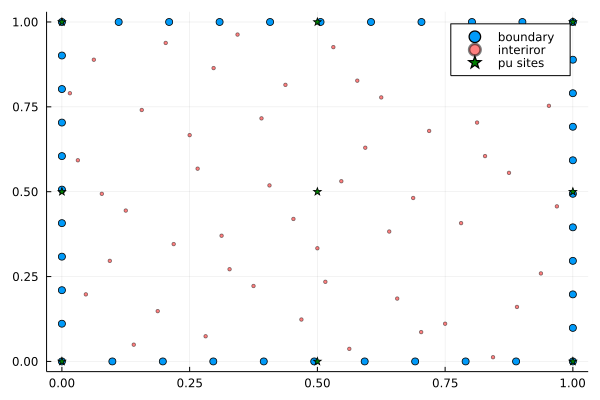

In [16]:
scatter([boundary_points[i][1] for i in 1:N_b*4], 
[boundary_points[i][2] for i in 1:N_b*4],label = "boundary ")
scatter!([interiror_points[i][1] for i in 1:N_i], 
[interiror_points[i][2] for i in 1:N_i], label="interiror", mc=:red, ms=2, ma=0.5)
scatter!(pu_sites[1,:] ,pu_sites[2,:] , label="pu sites", mc=:green, markershape =:star)

In [17]:
using TypedPolynomials
function Poly_functions_vec(deg,d_x,d_y)
    dim = 2 # number of dimensions
    Q = factorial(deg+dim-1)÷(factorial(dim)*factorial(deg-1))
    @polyvar x y
    T = Polynomial{Int64, Term{Int64, Monomial{(x, y), 2}}, Vector{Term{Int64, Monomial{(x, y), 2}}}}
    p_vec = Array{T,1}(undef, Q)
    counter = 1
    for i in 0:(deg-1)
        for j in 0:i
            p_vec[counter] = differentiate(differentiate(x^(i-j)*y^j, x, Val{d_x}()),y,Val{d_y}())
            counter+=1
        end
    end
    return p_vec
end

function ΔPoly_functions_vec(deg) #Laplacian operator for polynomials
    # returns a vector of functions 
    Δₓp = Poly_functions_vec(deg,2,0)
    Δᵥp = Poly_functions_vec(deg,0,2)
    return Δₓp+Δᵥp
end

function poly_evaluate(pol_list,a,b)
    @polyvar x y
    return [pol_list[i](x=>a,y=>b) for i in 1:length(pol_list)]
end
function Polynom_matrix(x_list,y_list,deg)
    n = length(x_list)
    dim = 2 # number of dimensions 
    Q = factorial(deg+dim-1)÷(factorial(dim)*factorial(deg-1))
    P = zeros(n,Q)
    P[:,1] = ones(n)
    counter = 1
    for i in 1:(deg-1)
        for j in 0:i
            counter+=1
            P[:,counter] = x_list.^(i-j) .* y_list.^j
        end
    end
    return Q,P
end


Polynom_matrix (generic function with 1 method)

In [22]:
# create list with all collocation points 
ϵ = 3
poly_degree = 4
points = vcat(interiror_points,boundary_points)
pure_points = metafree.(points) # list of points without metadata(this is compatible with other packages)
points_x = [pure_points[i][1] for i in 1:N]
points_y = [pure_points[i][2] for i in 1:N]
# create k-d tree for all points 
KD_tree = KDTree(pure_points,Euclidean(),leafsize = 3)
#create polynamoal and differentiated polynomial function vector 
poly = Poly_functions_vec(poly_degree,0,0)
Δpoly = ΔPoly_functions_vec(poly_degree)
# create empty sparce sparce matrix N by N 
A = spzeros(N,N)
Shepard_matrix = spzeros(N,N_pu^2)
max_cond_M = 1.0
max_cond_U = 1.0
for i in 1:N_pu^2
    # find all points that lie within iᵗʰ patch
    idxs_data = inrange(KD_tree, pu_sites[:,i], radius, true)
    p_x = points_x[idxs_data]
    p_y = points_y[idxs_data]
    # construct local phi Φ
    Dist_matrix = pairwise(Euclidean(), pure_points[idxs_data], pure_points[idxs_data])
    Φ = gaussian.(Dist_matrix,ϵ)
    # construct polynomial matrix P
    Q,P = Polynom_matrix(p_x,p_y,poly_degree)
    # combine these and invert
    M = vcat(hcat(Φ,P),hcat(P',zeros((Q,Q))))
    if cond(M)> max_cond_M
        max_cond_M = cond(M)
    end
    #display(M)
    M_inv = inv(M)
    inter_indexs = filter(x -> x <=N_i, idxs_data) # indexes to which apply laplace operator
    n_interiror = length(inter_indexs)
    n_boundary = length(idxs_data) - n_interiror
    R1 = Δgaussian.(Dist_matrix[:,1:n_interiror],ϵ)
    S1 = hcat(poly_evaluate.((Δpoly,),points_x[inter_indexs],points_y[inter_indexs])...)
    boundary_indexs = filter(x -> x >N_i, idxs_data) # indexes to which apply Boundary operator
    #println(poly_evaluate.((poly,),points_x[boundary_indexs],points_y[boundary_indexs]))
    if n_boundary==0 
            RS = vcat(R1,S1)
    else
        R2 = gaussian.(Dist_matrix[:,n_interiror+1:end],ϵ)
        S2 = hcat(poly_evaluate.((poly,),points_x[boundary_indexs],points_y[boundary_indexs])...)
        RS = hcat(vcat(R1,S1),vcat(R2,S2))
    end
    
    # Now the weight functions:
    
    U = (M_inv * RS)[1:end-Q,:]
    

    if cond(U)> max_cond_U
        max_cond_U = cond(U)
    end
    #print(cond(U),"  ")
     
    PU_weights = wendland_C2.(pairwise(Euclidean(), pure_points[idxs_data], [pu_sites[:,i]]),radius)
    #display(PU_weights)
    A[idxs_data,idxs_data] += U' .* PU_weights
    Shepard_matrix[idxs_data,i] = PU_weights
end

sdsd = sum(Shepard_matrix, dims=2).^-1
A = A .* sdsd # multiply by pu weigths 
# Assemble rhs
RHS = [points[i].value for i in 1:N]
#for i in 1:N
#    println(sum(abs.(Matrix(A)[i,:])))
#end
uu = A\RHS

println("max cond U ",max_cond_U)
println("max cond M ",max_cond_M)
#println("cond A ",cond(Matrix(A)))
display(A)

max cond U 5.539307200140603e17
max cond M 4.0226361465445384e7


90×90 SparseMatrixCSC{Float64, Int64} with 4474 stored entries:
⣿⣿⣿⣺⣿⣿⣿⣿⣿⣿⣿⡯⣿⣿⣿⣿⣿⢽⣿⣺⡧⣿⣯⣭⣭⠭⠭⠤⠤⠤⠤⠒⠒⠒⠒⢖⣒⣒⣒⣒
⣻⣻⣟⢝⣿⣟⣿⣟⣻⣻⣿⣏⣿⣛⣿⣯⣻⣻⣟⢝⡟⣽⣍⣉⣉⣉⣙⣛⣛⡛⠛⠭⠭⠿⠿⠯⠭⠭⠭⠭
⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⡯⣿⣿⣿⡯⣿⣿⣿⢿⣗⢽⠭⠭⠭⠭⢽⣒⣒⣒⣒⠒⠒⠒⠒⡪⠭⠭⠭⠽
⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⣏⣿⣿⣿⣗⣿⣹⣿⢿⡯⣺⣂⣀⣀⣉⣉⠉⠉⠩⠭⠿⠿⠭⠭⢕⣒⡚⠛⠻
⣿⣿⣿⣺⣿⣿⣿⣿⣿⣿⣿⡯⣿⣿⣿⣿⣿⢽⣿⣺⡯⣿⡯⠭⠭⠭⠭⠭⠭⠭⠭⣒⣒⣒⣒⣗⣒⣒⣒⣒
⡿⡿⡿⢿⡿⡿⡿⢿⡿⡿⠿⢇⡿⣿⡿⢏⡿⡻⡿⢿⡟⡹⣉⣉⣉⣀⣘⣛⣛⡛⠛⠿⠿⠿⠿⠏⠉⠩⠭⠽
⣿⣿⣿⢻⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⡯⣿⣿⣿⢻⣗⢽⠭⠭⠭⣭⣽⣒⣒⣒⣒⠒⠒⠒⠒⡪⠭⠍⠉⠙
⣿⣿⡿⣿⡿⡿⢿⢿⣿⣿⡿⢏⡿⡿⣿⢟⣿⣽⡿⣿⡧⣻⣋⣉⣉⣉⣩⠤⠤⠤⠤⠿⠿⠶⠶⢞⣛⣛⣛⣻
⣟⣟⣿⣺⣿⣿⣟⣻⣟⣟⣿⡫⣿⣿⣟⣿⣟⢝⣿⣺⡯⣿⣯⣭⣭⠭⠭⠭⠭⠭⠭⠒⠒⠒⠒⢗⣒⣒⣒⣒
⣻⣻⣟⢝⣿⣟⣿⣟⣻⣻⣿⣏⣿⣛⣿⣯⣻⣻⣟⢝⡟⣽⣍⣉⣉⣉⣙⣒⣒⡚⠛⠭⠭⠿⠿⠯⠭⠭⠭⠭
⣭⣯⣟⣭⣝⣝⣫⣫⣯⣯⣟⡩⣝⣝⣭⣫⣯⣯⣟⣭⣕⣽⡭⠭⠭⠭⢽⣒⣒⣒⣒⣀⣀⣒⣒⣪⣭⣭⣭⣭
⡆⣾⡇⢰⡇⡇⠀⢸⡆⡆⡇⢰⡇⡇⡆⢸⡆⣾⡇⢰⡆⡇⣿⣿⣿⣶⣶⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⡇⠀⠀
⡇⡟⡇⢸⡇⡇⡄⢸⡇⡇⠃⢸⡇⣧⡇⢸⡇⡟⡇⢸⡇⡇⣿⣿⣿⣿⣿⣤⣤⡄⠀⠀⠀⠀⠀⠘⠛⠃⠀⠀
⠁⡇⣥⢸⢡⢡⡇⠈⡇⡇⣤⢸⢡⢩⠁⡌⡅⡇⢡⢸⢡⢡⠉⠉⠉⣿⣿⣿⣿⣧⣤⠀⠀⠀⠀⡄⠀⠀⠀⠀
⠀⡇⣿⠸⢸⢸⡇⡀⡇⡇⣿⠸⢸⢸⠀⡇⡇⡇⣸⠘⢸⢸⠀⠀⠀⠟⢿⣿⣿⣿⣿⠀⠀⣀⣀⡇⠀⠀⠀⠀
⢠⠃⡟⡄⢘⠘⣧⡇⢣⢣⣿⡄⢸⠘⣤⡇⢣⠃⡟⡄⠘⢸⠀⠀⠀⠀⠘⠛⠛⠛⠛⣤⣤⣿⣿⡇⠀⢠⣤⣤
⢸⠀⣧⡇⢸⠀⡟⡇⢸⢸⣷⡇⢨⠀⢻⡇⢸⠀⣧⡇⢠⢸⠀⠀⠀⠀⠀⠀⠀⢠⣤⣿⣿⣿⣿⡇⠀⠘⠛⢻
⢘⢀⡿⡂⡸⡀⢃⢇⢘⢐⡟⠃⡸⡀⣘⢇⢘⢀⡿⡃⡸⣘⣀⣀⣀⠀⠀⠀⠀⠸⠞⠛⠛⠿⠿⢇⣀⣀⣀⣘
⢸⢸⡇⡇⡇⡇⣸⠸⢸⢸⡇⡀⡇⠇⣿⢸⢸⢸⡇⡇⡇⣿⡿⠿⠿⠀⠀⠀⠀⠀⠀⣀⣀⠀⠀⢸⣿⣿⣿⣿
⢸⠸⠇⡇⠇⠇⣿⠀⢸⠸⠇⡇⠇⠀⡿⠸⢸⠸⠇⡇⠇⢿⠇⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠸⠿⢿⣿⣿

In [23]:
1160*1160

1345600

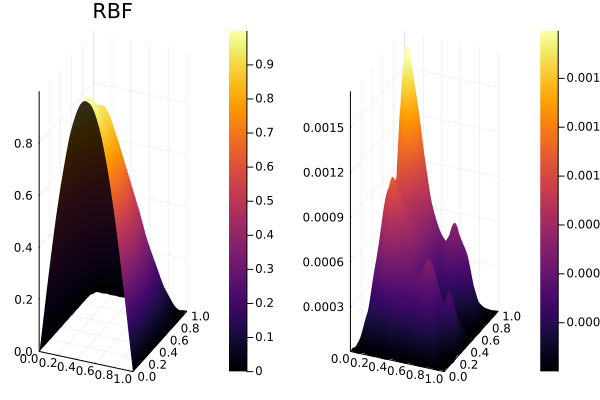

In [24]:
p1 = surface(points_x,points_y,uu,title = "RBF")
p2 = surface(points_x,points_y,abs.((uu .- exact_solution.(points_x,points_y))))
plot(p1,p2)

In [220]:
typeof(Euclidean)

DataType